<a href="https://colab.research.google.com/github/taekyungss/Naver_BoostCourse/blob/main/health_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 음주 여부에 따라 건강검진 수치 차이가 있을까?
##  신장과 허리둘레의 크기는 체중과 상관관계가 있을까?

* 분석을 통해 가설을 검정해 봅니다.

## 라이브러리 로드

## 한글폰트 설정

In [1]:
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (9,956 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 129504 files and di

In [2]:
# 분석에 사용할 pandas, 수치계산에 사용할 numpy, 시각화에 사용할 seaborn 을 불러옵니다.
# 또, 구 버전의 주피터 노트북에서는 %matplotlib inline 설정을 되어야 노트북 안에서 그래프를 시각화 합니다.
!pip install koreanize-matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

import pandas as pd
import seaborn as sns
import numpy as np
import koreanize_matplotlib
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 61.7 MB/s eta 0:00:00


In [84]:
!apt -qq -y install fonts-nanum > /dev/null
plt.rc('font', family='NanumGothic') 

## 데이터 불러오기
* 건강검진정보란 2002년부터 2013년까지의 국민건강보험의 직장가입자와 40세 이상의 피부양자, 세대주인 지역가입자와 40세 이상의 지역가입자의 일반건강검진 결과와 이들 일반건강검진 대상자 중에 만40세와 만66세에 도달한 이들이 받게 되는 생애전환기건강진단 수검이력이 있는 각 연도별 수진자 100만 명에 대한 기본정보(성, 연령대, 시도코드 등)와 검진내역(신장, 체중, 총콜레스테롤, 혈색소 등)으로 구성된 개방데이터이다.

공공데이터 개방서비스( http://nhiss.nhis.or.kr/op/it/index.do )에서도 다운로드 받을 수 있음.

* 건강검진정보(2018) 다운로드 받기 : https://www.data.go.kr/dataset/15007122/fileData.do
* 2019년 데이터로 실습을 하셔도 됩니다. 다만 encoding과 컬럼명이 달라서 2019년 데이터에 맞게 고쳐주시면 됩니다.
* 2019년 외 다른 연도의 데이터로도 실습을 하고자 한다면 컬럼명과 인코딩에 주의해 주세요.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 다운로드 받은 파일을 판다스의 read_csv 를 통해 읽어옵니다.
# 파일을 읽어온 후 shape 로 행과 열의 수를 출력합니다.

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/boostcourse/NHIS_OPEN_GJ_2017_v1.1.csv", encoding="cp949")
df.shape

(1000000, 34)

### 데이터 미리보기

In [5]:
# sample, head, tail을 통해 데이터를 미리보기 합니다.
df.sample(10)

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),...,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
538764,2017,538765,2,10,41,160,55,73.1,0.9,0.7,...,15.0,3.0,Y,Y,NaN,NaN,NaN,NaN,N,2018-11-26
990060,2017,990061,2,12,11,145,60,84.0,1.0,0.5,...,12.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
711400,2017,711401,1,5,47,170,75,79.0,1.5,1.5,...,12.0,3.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26
320115,2017,320116,1,10,47,170,75,83.5,1.2,0.8,...,108.0,2.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
799697,2017,799698,1,7,28,170,75,81.0,0.8,1.0,...,18.0,1.0,Y,Y,NaN,NaN,NaN,NaN,N,2018-11-26
983920,2017,983921,2,13,28,155,60,81.0,0.7,0.4,...,15.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
403846,2017,403847,1,11,41,170,65,83.0,1.2,0.9,...,20.0,3.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
57049,2017,57050,2,14,46,160,65,86.0,1.0,0.5,...,16.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
710985,2017,710986,1,11,48,170,75,89.7,1.0,0.7,...,25.0,2.0,Y,Y,NaN,NaN,NaN,NaN,N,2018-11-26
247630,2017,247631,1,15,50,170,75,90.0,0.9,0.9,...,37.0,1.0,Y,N,NaN,NaN,NaN,NaN,NaN,2018-11-26


## 기본정보 보기

In [6]:
# info를 통해 데이터의 크기, 형식, 메모리 사용량 등을 봅니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   기준년도          1000000 non-null  int64  
 1   가입자일련번호       1000000 non-null  int64  
 2   성별코드          1000000 non-null  int64  
 3   연령대코드(5세단위)   1000000 non-null  int64  
 4   시도코드          1000000 non-null  int64  
 5   신장(5Cm단위)     1000000 non-null  int64  
 6   체중(5Kg단위)     1000000 non-null  int64  
 7   허리둘레          999734 non-null   float64
 8   시력(좌)         999817 non-null   float64
 9   시력(우)         999811 non-null   float64
 10  청력(좌)         999842 non-null   float64
 11  청력(우)         999844 non-null   float64
 12  수축기혈압         999981 non-null   float64
 13  이완기혈압         999982 non-null   float64
 14  식전혈당(공복혈당)    999958 non-null   float64
 15  총콜레스테롤        999957 non-null   float64
 16  트리글리세라이드      999955 non-null   float64
 17  HDL콜레스테롤      999956 non-nul

In [7]:
# 컬럼의 수가 많습니다. 컬럼만 따로 출력합니다.
df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [8]:
# dtypes 를 통해 데이터 형식만 출력합니다.
df.dtypes

기준년도              int64
가입자일련번호           int64
성별코드              int64
연령대코드(5세단위)       int64
시도코드              int64
신장(5Cm단위)         int64
체중(5Kg단위)         int64
허리둘레            float64
시력(좌)           float64
시력(우)           float64
청력(좌)           float64
청력(우)           float64
수축기혈압           float64
이완기혈압           float64
식전혈당(공복혈당)      float64
총콜레스테롤          float64
트리글리세라이드        float64
HDL콜레스테롤        float64
LDL콜레스테롤        float64
혈색소             float64
요단백             float64
혈청크레아티닌         float64
(혈청지오티)AST      float64
(혈청지오티)ALT      float64
감마지티피           float64
흡연상태            float64
음주여부             object
구강검진수검여부         object
치아우식증유무         float64
결손치유무           float64
치아마모증유무         float64
제3대구치(사랑니)이상    float64
치석               object
데이터공개일자          object
dtype: object

## 결측치 보기

In [9]:
# isnull 을 통해 결측치를 bool 값으로 표시하고 sum을 하면 컬럼마다의 결측치 수를 세어줍니다.
df.isnull().sum()

기준년도                  0
가입자일련번호               0
성별코드                  0
연령대코드(5세단위)           0
시도코드                  0
신장(5Cm단위)             0
체중(5Kg단위)             0
허리둘레                266
시력(좌)               183
시력(우)               189
청력(좌)               158
청력(우)               156
수축기혈압                19
이완기혈압                18
식전혈당(공복혈당)           42
총콜레스테롤               43
트리글리세라이드             45
HDL콜레스테롤             44
LDL콜레스테롤           2912
혈색소                  52
요단백                4592
혈청크레아티닌              43
(혈청지오티)AST           41
(혈청지오티)ALT           42
감마지티피                42
흡연상태                144
음주여부                536
구강검진수검여부              0
치아우식증유무         1000000
결손치유무           1000000
치아마모증유무         1000000
제3대구치(사랑니)이상    1000000
치석               621422
데이터공개일자               0
dtype: int64

In [10]:
# isna로도 결측치 여부를 확인하고 sum을 통해 결측치 수를 집계할 수 있습니다.
df.isna().sum()

기준년도                  0
가입자일련번호               0
성별코드                  0
연령대코드(5세단위)           0
시도코드                  0
신장(5Cm단위)             0
체중(5Kg단위)             0
허리둘레                266
시력(좌)               183
시력(우)               189
청력(좌)               158
청력(우)               156
수축기혈압                19
이완기혈압                18
식전혈당(공복혈당)           42
총콜레스테롤               43
트리글리세라이드             45
HDL콜레스테롤             44
LDL콜레스테롤           2912
혈색소                  52
요단백                4592
혈청크레아티닌              43
(혈청지오티)AST           41
(혈청지오티)ALT           42
감마지티피                42
흡연상태                144
음주여부                536
구강검진수검여부              0
치아우식증유무         1000000
결손치유무           1000000
치아마모증유무         1000000
제3대구치(사랑니)이상    1000000
치석               621422
데이터공개일자               0
dtype: int64

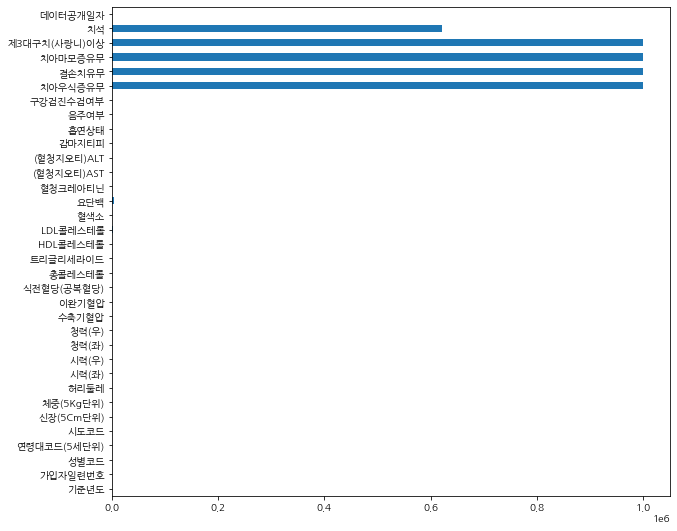

In [11]:
# 판다스에 내장 된 plot을 통해 시각화를 합니다.
df.isnull().sum().plot.barh(figsize=(10,9))

## 일부 데이터 요약하기

In [12]:
# 여러 컬럼을 가져옵니다. 
# "(혈청지오티)ALT", "(혈청지오티)AST" 를 가져와 미리보기 합니다.

df[['(혈청지오티)ALT','(혈청지오티)AST']].head()

,(혈청지오티)ALT,(혈청지오티)AST
0,35.0,21.0
1,36.0,20.0
2,32.0,47.0
3,34.0,29.0
4,12.0,19.0


In [13]:
# "(혈청지오티)ALT", "(혈청지오티)AST" 를 요약합니다.
df[['(혈청지오티)ALT','(혈청지오티)AST']].describe()

,(혈청지오티)ALT,(혈청지오티)AST
count,999958.000000,999959.000000
mean,25.749509,25.994671
std,26.294770,23.587469
min,1.000000,1.000000
25%,15.000000,19.000000
50%,20.000000,23.000000
75%,29.000000,28.000000
max,7210.000000,9999.000000


In [14]:
df.head()

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),...,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
0,2017,1,1,8,43,170,75,90.0,1.0,1.0,...,40.0,1.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
1,2017,2,1,7,11,180,80,89.0,0.9,1.2,...,27.0,3.0,N,Y,NaN,NaN,NaN,NaN,NaN,2018-11-26
2,2017,3,1,9,41,165,75,91.0,1.2,1.5,...,68.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
3,2017,4,1,11,48,175,80,91.0,1.5,1.2,...,18.0,1.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26
4,2017,5,1,11,30,165,60,80.0,1.0,1.2,...,25.0,1.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26


## value_counts 로 값 집계하기

성별코드 1 : 남자, 2: 여자

In [15]:
# value_counts 를 통해 성별코드로 그룹화 하고 갯수를 집계합니다.
df["성별코드"].value_counts()

1    530410
2    469590
Name: 성별코드, dtype: int64

In [16]:
# value_counts 를 통해 흡연상태로 그룹화 하고 갯수를 집계합니다.
df["흡연상태"].value_counts()

1.0    607942
3.0    215702
2.0    176212
Name: 흡연상태, dtype: int64

## groupby 와 pivot_table 사용하기

### groupby

In [17]:
# groupby를 통해 데이터를 그룹화 합니다.
# 성별코드로 그룹화 한 데이터를 세어 봅니다.
df.groupby(["성별코드"])["가입자일련번호"].count()

성별코드
1    530410
2    469590
Name: 가입자일련번호, dtype: int64

In [18]:
# 성별코드와 음주여부로 그룹화를 하고 갯수를 세어봅니다.
df.groupby(["성별코드", "음주여부"])["가입자일련번호"].count()

성별코드  음주여부
1     N       173612
      Y       356587
2     N       326827
      Y       142438
Name: 가입자일련번호, dtype: int64

In [19]:
# 성별코드와 음주여부로 그룹화를 하고 감마지티피의 평균을 구합니다.
df.groupby(["성별코드","음주여부"])["감마지티피"].mean()

성별코드  음주여부
1     N       34.739868
      Y       56.610981
2     N       22.612408
      Y       25.001018
Name: 감마지티피, dtype: float64

In [20]:
# 성별코드와 음주여부로 그룹화를 하고 감마지티피의 요약수치를 구합니다.
df.groupby(["성별코드",'음주여부'])["감마지티피"].describe()

count       mean        std  min   25%   50%   75%    max
성별코드 음주여부                                                              
1    N     173604.0  34.739868  37.606197  1.0  18.0  25.0  38.0  999.0
     Y     356576.0  56.610981  68.851128  1.0  24.0  37.0  63.0  999.0
2    N     326813.0  22.612408  25.203579  1.0  13.0  17.0  24.0  999.0
     Y     142429.0  25.001018  36.725100  1.0  13.0  17.0  25.0  999.0

In [21]:
# agg을 사용하면 여러 수치를 함께 구할 수 있습니다.
df.groupby(["성별코드",'음주여부'])["감마지티피"].agg(["count",'mean','median'])

count       mean  median
성별코드 음주여부                           
1    N     173604  34.739868    25.0
     Y     356576  56.610981    37.0
2    N     326813  22.612408    17.0
     Y     142429  25.001018    17.0

### pivot_table
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

In [22]:
# 음주여부에 따른 그룹화된 수를 피봇테이블로 구합니다.
df.pivot_table(index="음주여부", values="가입자일련번호", aggfunc="count")

,가입자일련번호
음주여부,
N,500439
Y,499025


In [23]:
# 음주여부에 따른 감마지티피의 평균을 구합니다. / 기본값은 평균
df.pivot_table(index="음주여부", values="감마지티피")

,감마지티피
음주여부,
N,26.819650
Y,47.588675


In [24]:
# 기본값은 평균을 구하지만 aggfunc을 통해 지정해 줄 수도 있습니다.
df.pivot_table(index="음주여부", values="감마지티피", aggfunc="mean")

,감마지티피
음주여부,
N,26.819650
Y,47.588675


In [25]:
# aggfunc에 여러 값을 한번에 지정할 수도 있습니다.
df.pivot_table(index="음주여부", values="감마지티피", aggfunc=["mean","median"])

,mean,median
,감마지티피,감마지티피
음주여부,,
N,26.819650,19.0
Y,47.588675,30.0


In [26]:
# aggfunc에 describe를 사용해 통계요약값을 한번에 볼 수도 있습니다.
df.pivot_table(index="음주여부", values="감마지티피", aggfunc="describe")

,25%,50%,75%,count,max,mean,min,std
음주여부,,,,,,,,
N,14.0,19.0,29.0,500417.0,999.0,26.819650,1.0,30.639714
Y,18.0,30.0,52.0,499005.0,999.0,47.588675,1.0,63.056912


In [27]:
# 성별코드, 음주여부에 따른 감마지티피 값의 평균을 구합니다.
df.pivot_table(index=["성별코드","음주여부"], values="감마지티피", aggfunc="describe")

25%   50%   75%     count    max       mean  min        std
성별코드 음주여부                                                              
1    N     18.0  25.0  38.0  173604.0  999.0  34.739868  1.0  37.606197
     Y     24.0  37.0  63.0  356576.0  999.0  56.610981  1.0  68.851128
2    N     13.0  17.0  24.0  326813.0  999.0  22.612408  1.0  25.203579
     Y     13.0  17.0  25.0  142429.0  999.0  25.001018  1.0  36.725100

## 전체 데이터 시각화 하기
* 100만개가 넘는 데이터를 시각화할 때는 되도록이면 groupby 혹은 pivot_table로 연산을 하고 시각화를 하는 것을 권장합니다.
* 100만개가 넘는 데이터를 seaborn과 같은 고급 통계 연산을 하는 그래프를 사용하게 되면 많이 느릴 수 있습니다.

### 히스토그램
* 판다스의 info 기능을 통해 대부분 수치 데이터로 이루어 진것을 확인할 수 있었습니다. 
* 히스토그램을 사용하면 수치데이터를 bin 의 갯수만큼 그룹화 해서 도수분포표를 만들고 그 결과를 시각화 합니다.
* 이 데이터에는 수치데이터가 많기 때문에 판다스의 hist를 사용해서 히스토그램을 그립니다.

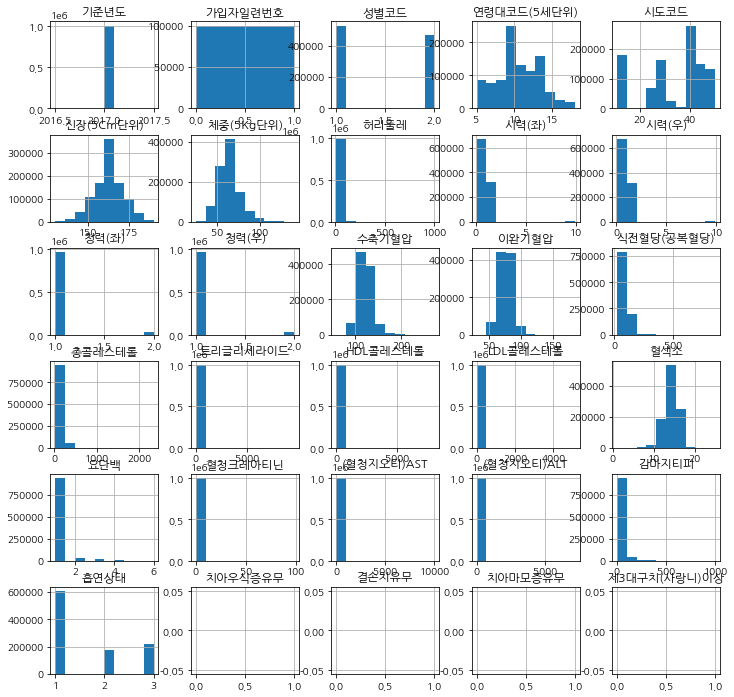

In [28]:
# 전체 데이터에 대한 히스토그램을 출력합니다.
h = df.hist(figsize=(12,12))


### 슬라이싱을 사용해 히스토그램 그리기
* 슬라이싱 기능을 사용해서 데이터를 나누어 그립니다.
* 슬라이싱 사용시 iloc를 활용하면 인덱스의 순서대로 슬라이싱이 가능합니다.
* iloc[행, 열] 순으로 인덱스를 써주면 해당 인덱스만 불러오며, 전체 데이터를 가져오고자 할 때는 [:, :]을 사용합니다.
* 슬라이싱을 해주는 대괄호 안의 콜론 앞뒤에 숫자를 써주게 되면 해당 시작인덱스:끝나는인덱스(+1)를 지정할 수 있습니다.

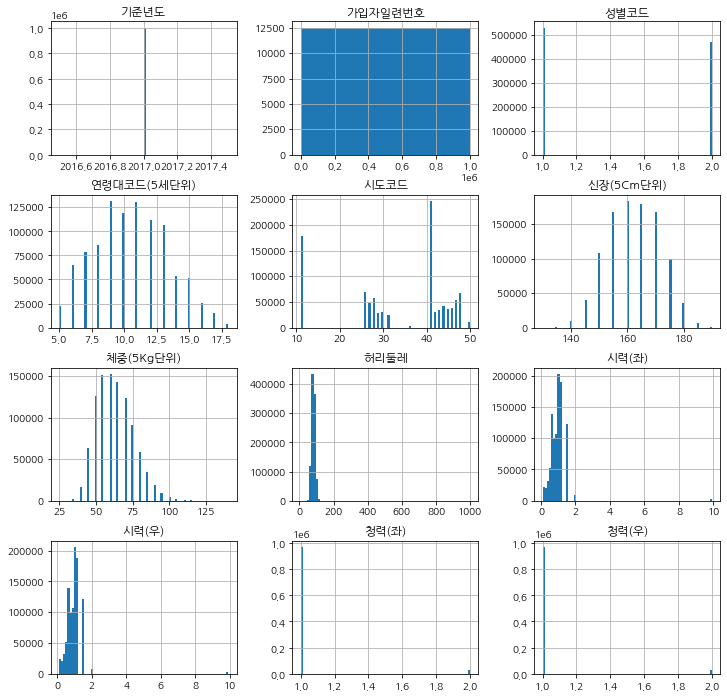

In [29]:
# 슬라이싱을 사용해 앞에서 12개 컬럼에 대한 데이터로 히스토그램을 그립니다.
# [행, 열]
h = df.iloc[:, :12].hist(figsize=(12,12),bins=80)

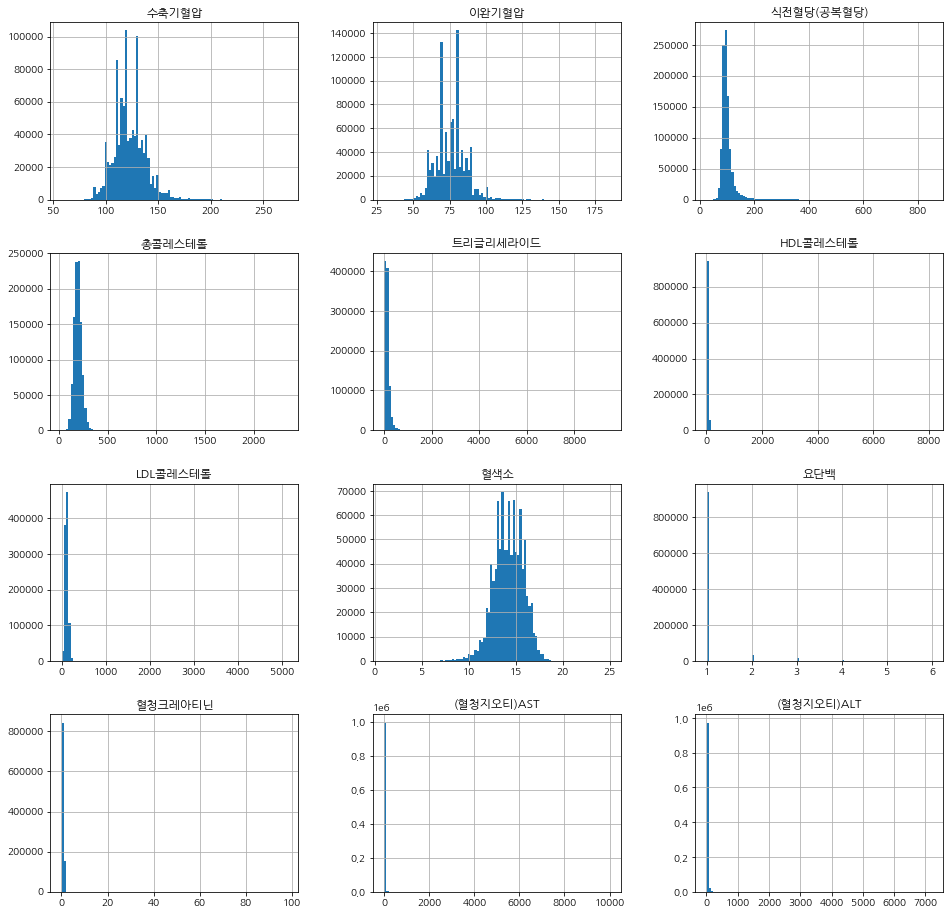

In [30]:
# 슬라이싱을 사용해 앞에서 12번째부터 23번째까지(12:24) 컬럼에 대한 데이터로 히스토그램을 그립니다.
h = df.iloc[:,12:24].hist(figsize=(16,16), bins=100)

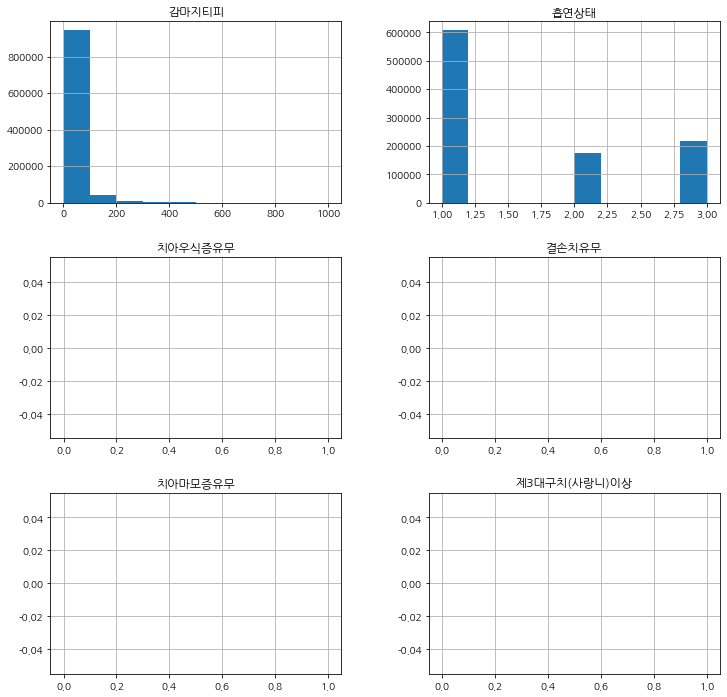

In [31]:
# 슬라이싱을 사용해 앞에서 24번째부터 마지막까지(24:) 컬럼에 대한 데이터로 히스토그램을 그립니다.
h = df.iloc[:, 24:].hist(figsize=(12,12),bins=10)


## 샘플데이터 추출하기
* seaborn 의 그래프는 내부에서 수학적 연산이 되기 때문에 데이터가 많으면 속도가 오래 걸립니다.
* 따라서 전체 데이터를 사용하면 너무 느리기 때문에 일부만 샘플링해서 사용합니다.

In [32]:
# df.sample을 통해 일부 데이터만 샘플데이터를 추출합니다. 
# random_state 를 사용해 샘플링되는 값을 고정할 수 있습니다.
# 실험을 통제하기 위해 random_state를 고정하기도 합니다. 
# 여기에서는 1을 사용하겠습니다. 이 값은 높든 낮든 상관 없이 값을 고정시키는 역할만 합니다.

df_sample = df.sample(1000, random_state = 1)
df_sample.shape

(1000, 34)

## 데이터 시각화 도구 Seaborn 사용하기
* https://seaborn.pydata.org/
* seaborn 은 https://matplotlib.org/ 을 사용하기 쉽게 만들어 졌으며, 간단하게 고급 통계 연산을 할 수 있습니다.

## 범주형(카테고리) 데이터 시각화
* countplot은 범주형 데이터의 수를 더한 값을 그래프로 표현합니다.
* value_counts 로 구한 값을 시각화 한다고 보면 됩니다.

### countplot - 음주여부

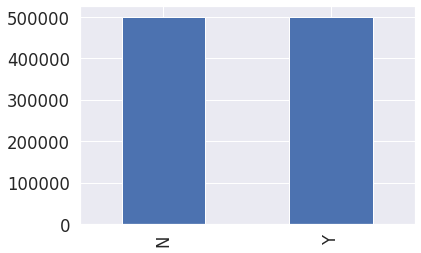

In [81]:
# 음주여부에 따른 countplot을 그립니다.
df["음주여부"].value_counts().plot.bar()

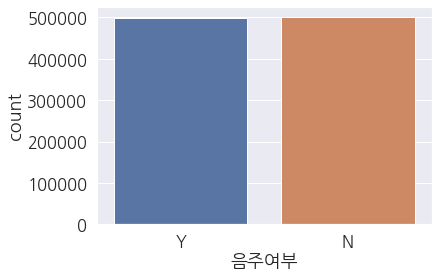

In [85]:
sns.countplot(x="음주여부", data =df)

### hue 옵션 사용하기

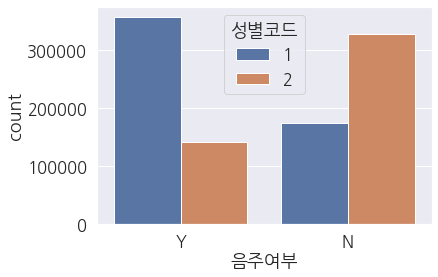

In [89]:
# 음주여부에 따른 countplot을 그리고 hue 를 사용해 성별코드로 색상을 구분해 그립니다.
# 여기에서 hue는 포토샵에 있는 hue 메뉴를 떠올리면 됩니다. 색상을 의미합니다.
# 또, seaborn 에서 제공하는 폰트 설정을 사용하실 수도 있습니다.
# 다만, 이 때 seaborn 의 기본 스타일이 적용되는 것을 확인해 주시는 것이 좋습니다.
# Window
sns.set(font_scale=1.5, font="NanumGothic")
sns.countplot(data = df, x="음주여부",hue="성별코드")

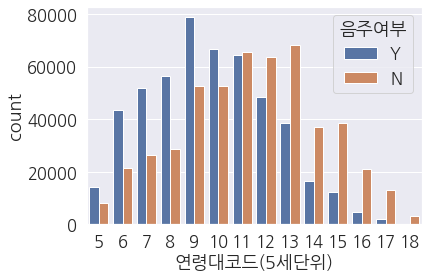

In [90]:
# countplot으로 연령대별 음주여부를 봅니다.
# hue를 사용해 다른 색상으로 표현합니다.
sns.countplot(data = df, x="연령대코드(5세단위)",hue="음주여부")

### countplot - 키와 몸무게
* 키와 몸무게는 연속형 데이터라고 볼 수 있습니다. 
* 하지만 이 데이터는 키는 5cm, 체중은 5kg 단위로 되어 있습니다. 
* 이렇게 특정 범위로 묶게 되면 연속형 데이터라기 보다는 범주형 데이터라고 볼 수 있습니다.

In [37]:
df.head()

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),...,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
0,2017,1,1,8,43,170,75,90.0,1.0,1.0,...,40.0,1.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
1,2017,2,1,7,11,180,80,89.0,0.9,1.2,...,27.0,3.0,N,Y,NaN,NaN,NaN,NaN,NaN,2018-11-26
2,2017,3,1,9,41,165,75,91.0,1.2,1.5,...,68.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
3,2017,4,1,11,48,175,80,91.0,1.5,1.2,...,18.0,1.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26
4,2017,5,1,11,30,165,60,80.0,1.0,1.2,...,25.0,1.0,N,Y,NaN,NaN,NaN,NaN,N,2018-11-26


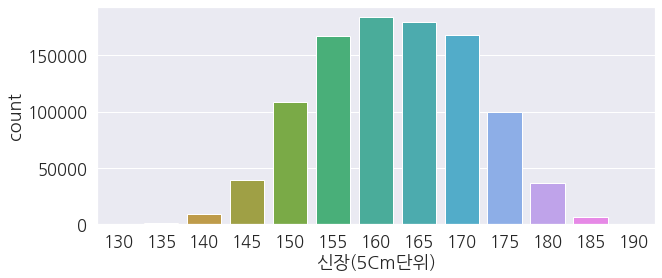

In [91]:
# counplot으로 키를 봅니다.
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="신장(5Cm단위)",)

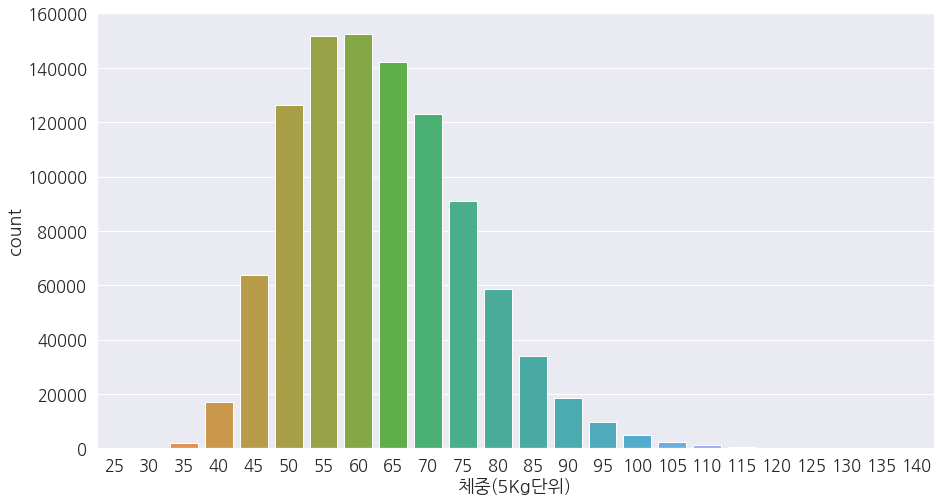

In [92]:
# counplot으로 체중을 봅니다.
plt.figure(figsize=(15,8))
sns.countplot(data=df, x="체중(5Kg단위)")

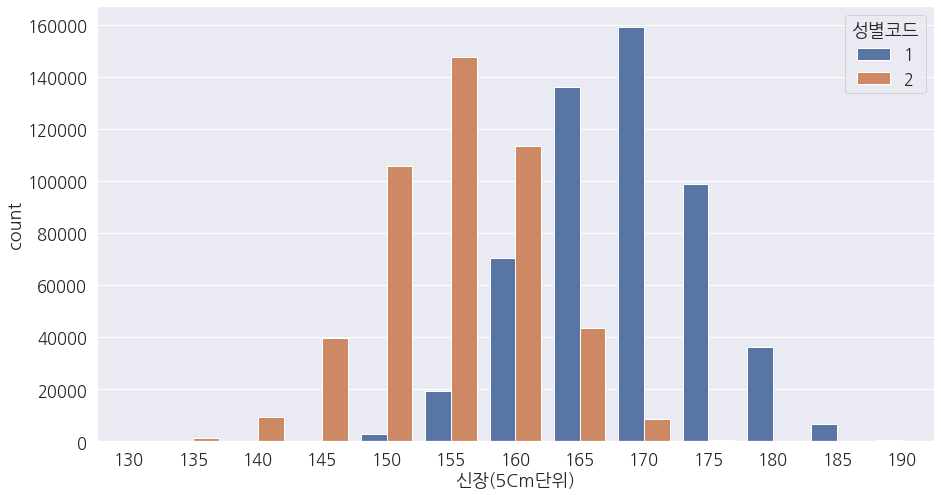

In [93]:
# counplot으로 신장(5Cm단위)를 봅니다.
# 성별에 따른 키의 차이를 봅니다.

plt.figure(figsize=(15,8))
sns.countplot(data=df, x="신장(5Cm단위)", hue="성별코드")

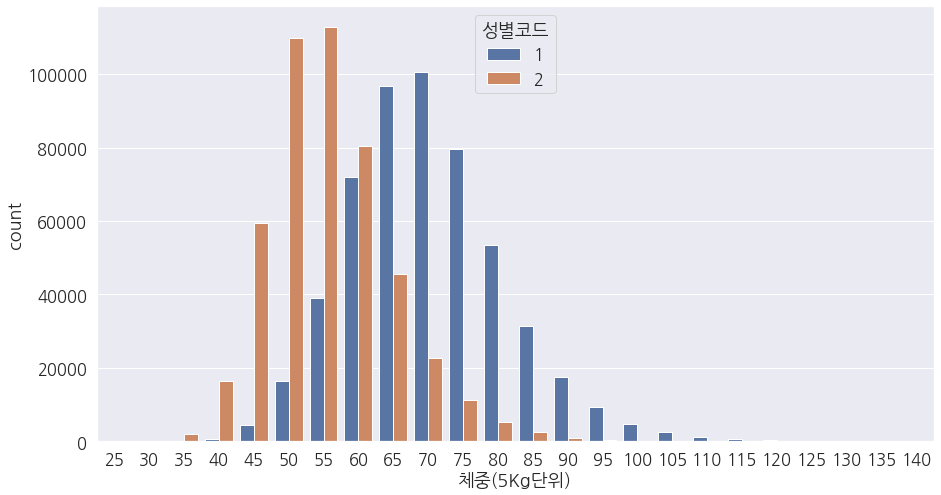

In [94]:
# 성별에 따른 체중의 차이를 봅니다.

plt.figure(figsize=(15,8))
sns.countplot(data=df, x="체중(5Kg단위)", hue="성별코드")

In [100]:
df_sample.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

### barplot - 수치형 vs 범주형 데이터 시각화

In [99]:
df_sample.head()

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),...,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
276826,2017,276827,1,12,41,160,55,77.0,0.9,0.9,...,38.0,3.0,Y,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
849425,2017,849426,1,9,31,170,75,89.9,1.0,1.0,...,28.0,3.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
504499,2017,504500,1,8,42,170,75,86.3,1.5,1.5,...,121.0,3.0,Y,Y,NaN,NaN,NaN,NaN,Y,2018-11-26
601054,2017,601055,1,14,31,170,70,84.0,0.8,0.9,...,31.0,3.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26
980221,2017,980222,1,17,41,160,60,86.0,0.7,0.5,...,28.0,1.0,N,N,NaN,NaN,NaN,NaN,NaN,2018-11-26


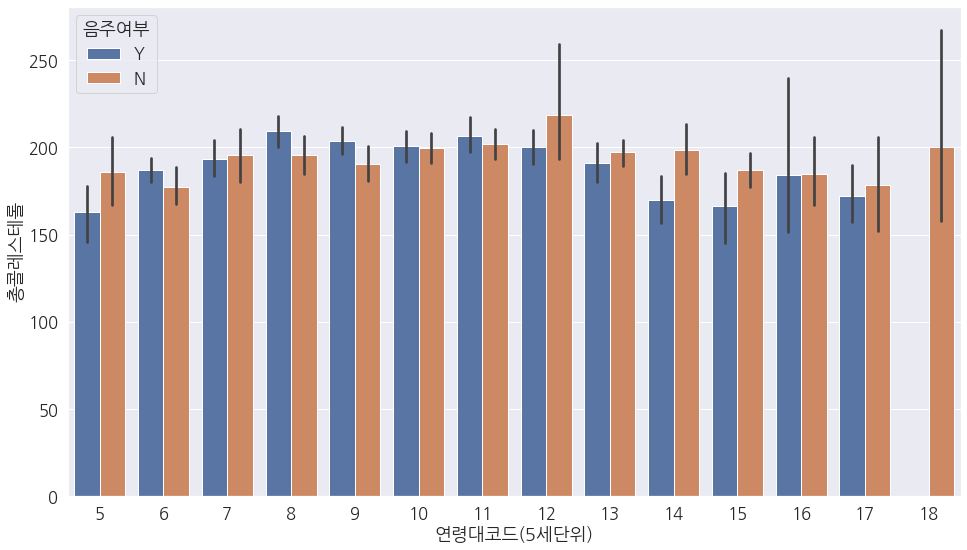

In [98]:
# 연령대코드와 총 콜레스테롤을 봅니다.
# hue 로 색상을 다르게 표현할 수 있습니다. 음주여부를 함께 봅니다.

plt.figure(figsize=(16,9))
sns.barplot(data=df_sample, x="연령대코드(5세단위)", y="총콜레스테롤", hue = "음주여부")

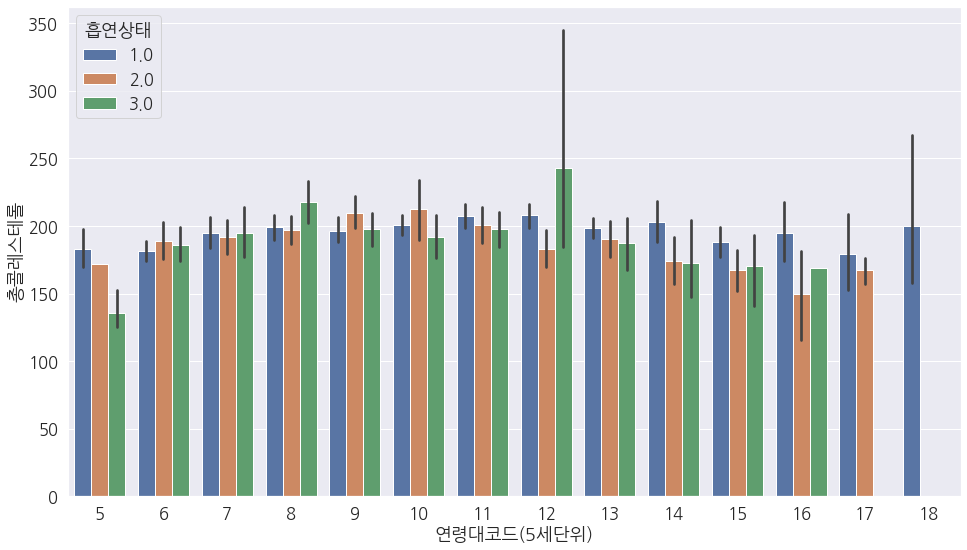

In [101]:
# 연령대코드와 총 콜레스테롤을 봅니다.
# 콜레스테롤과 연령대코드(5세단위)를 흡연상태에 따라 barplot으로 그립니다.

plt.figure(figsize=(16,9))
sns.barplot(data=df_sample ,x="연령대코드(5세단위)", y="총콜레스테롤", hue = '흡연상태' )

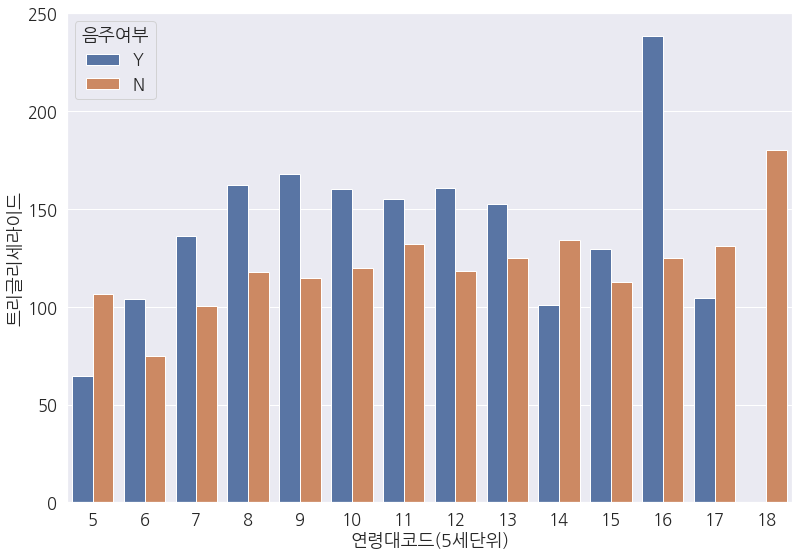

In [112]:
# 트리글리세라이드(중성지방) 에 따른 연령대코드(5세단위)를 음주여부에 따라 barplot으로 그립니다.
plt.figure(figsize=(13,9))
sns.barplot(data=df_sample, x="연령대코드(5세단위)", y="트리글리세라이드", hue = '음주여부',ci=None)

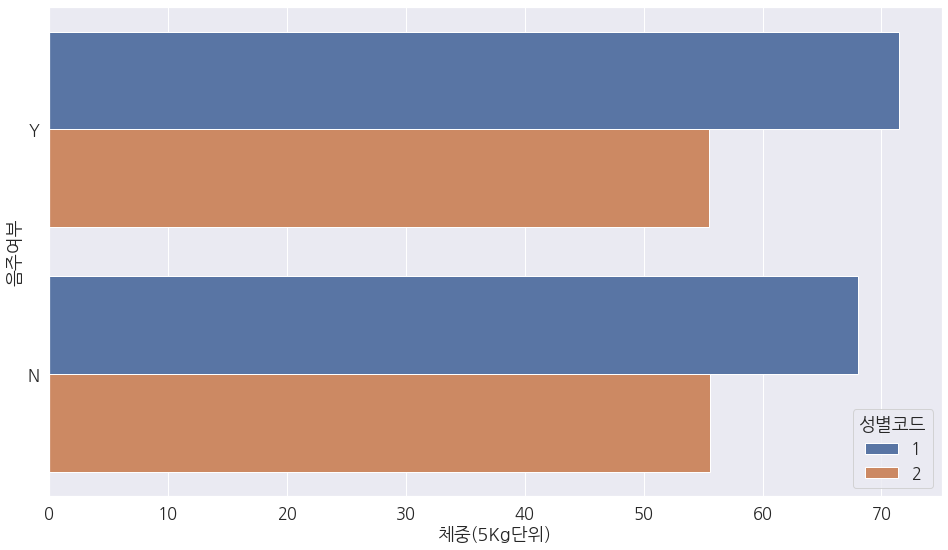

In [111]:
# 음주여부와 체중(5Kg 단위)을 성별에 따라 봅니다.

plt.figure(figsize=(16,9))
sns.barplot(data=df_sample, x="체중(5Kg단위)", y="음주여부", hue="성별코드", ci=None)

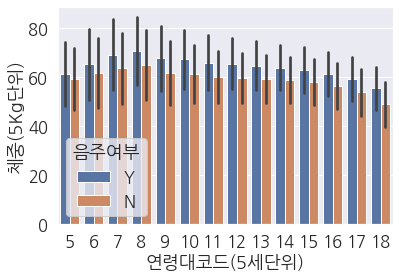

In [114]:
# 연령대코드(5세단위) 에 따른 체중(5Kg 단위) 을 음주여부에 따라 barplot으로 그립니다.
sns.barplot(data=df, x="연령대코드(5세단위)", y="체중(5Kg단위)", hue="음주여부", ci="sd")

### lineplot and pointplot

In [122]:
df_sample["연령대코드(5세단위)"]

276826    12
849425     9
504499     8
601054    14
980221    17
          ..
890013     8
875389    11
358458     9
808228    11
317698     9
Name: 연령대코드(5세단위), Length: 1000, dtype: int64

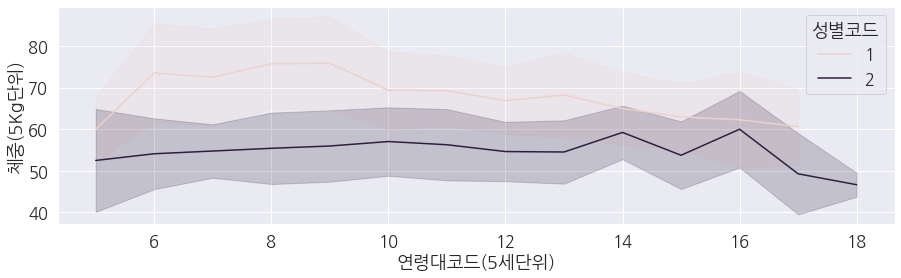

In [123]:
# 연령대코드(5세단위) 에 따른 체중(5Kg 단위) 을 성별코드에 따라 lineplot으로 그립니다.
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_sample, x="연령대코드(5세단위)", y="체중(5Kg단위)", hue="성별코드", ci="sd")

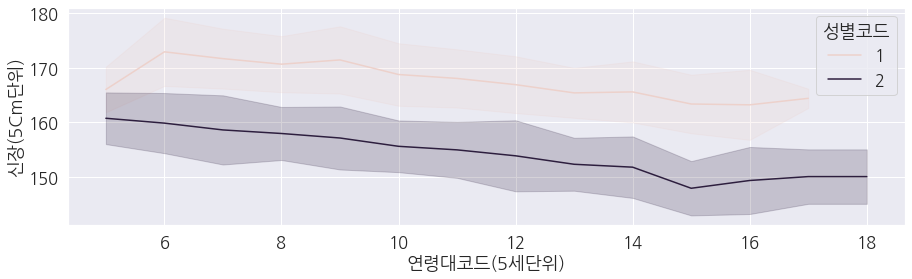

In [124]:
# 연령대코드(5세단위) 에 따른 신장(5Cm단위) 을 성별코드에 따라 lineplot으로 그립니다.
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_sample, x="연령대코드(5세단위)", y="신장(5Cm단위)", hue="성별코드", ci="sd")

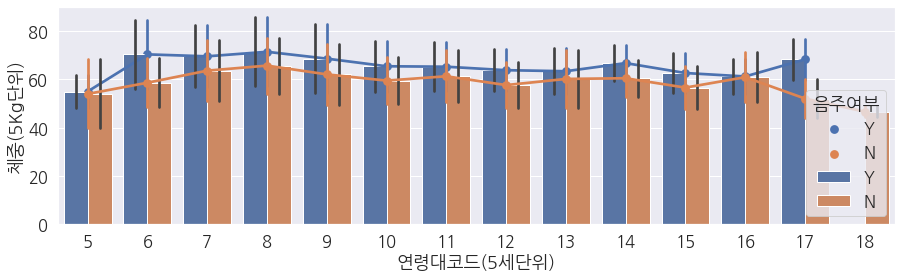

In [127]:
# 연령대코드(5세단위) 에 따른 체중(5Kg 단위) 을 음주여부에 따라 pointplot과 barplot으로 그립니다.
plt.figure(figsize=(15, 4))
sns.barplot(data=df_sample, x="연령대코드(5세단위)", y="체중(5Kg단위)", hue="음주여부", ci="sd")
sns.pointplot(data=df_sample, x="연령대코드(5세단위)", y="체중(5Kg단위)", hue="음주여부", ci="sd")


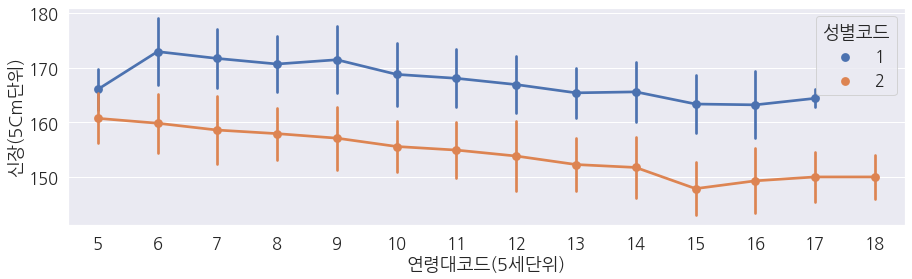

In [128]:
# 연령대코드(5세단위) 에 따른 신장(5Cm단위) 을 성별코드에 따라 pointplot으로 그립니다.
plt.figure(figsize=(15, 4))
sns.pointplot(data=df_sample, x="연령대코드(5세단위)", y="신장(5Cm단위)", hue="성별코드", ci="sd")


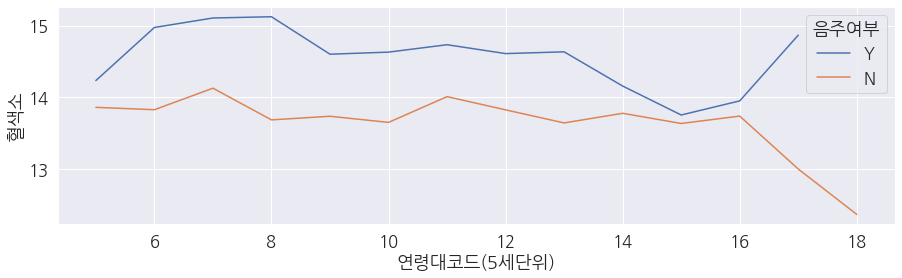

In [131]:
# 연령대코드(5세단위) 에 따른 혈색소를 음주여부에 따라 lineplot으로 그립니다.
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_sample, x="연령대코드(5세단위)", y="혈색소", hue="음주여부", ci=None)

### boxplot

* https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html

* [상자 수염 그림 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%83%81%EC%9E%90_%EC%88%98%EC%97%BC_%EA%B7%B8%EB%A6%BC)
* 가공하지 않은 자료 그대로를 이용하여 그린 것이 아니라, 자료로부터 얻어낸 통계량인 5가지 요약 수치로 그린다.
* 5가지 요약 수치란 기술통계학에서 자료의 정보를 알려주는 아래의 다섯 가지 수치를 의미한다.


1. 최솟값
1. 제 1사분위수
1. 제 2사분위수( ), 즉 중앙값
1. 제 3 사분위 수( )
1. 최댓값

* Box plot 이해하기 : 
    * [박스 플롯에 대하여 :: -[|]- Box and Whisker](https://boxnwhis.kr/2019/02/19/boxplot.html)
    * [Understanding Boxplots – Towards Data Science](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

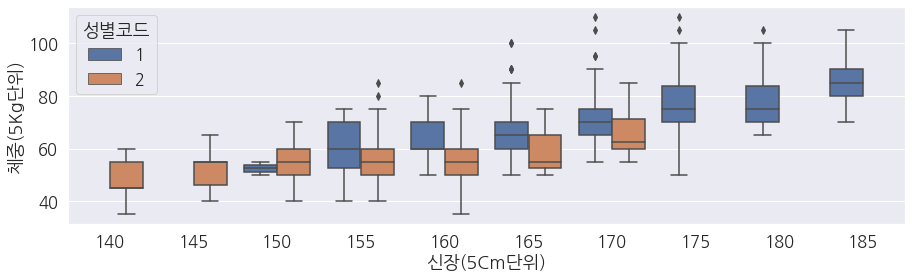

In [132]:
# boxplot으로 신장(5Cm단위) 에 따른 체중(5Kg 단위) 을 그리며, 성별코드에 따라 다른 색상으로 표현되게 합니다.
plt.figure(figsize=(15,4))
sns.boxplot(data=df_sample, x='신장(5Cm단위)', y='체중(5Kg단위)', hue='성별코드')

### violinplot

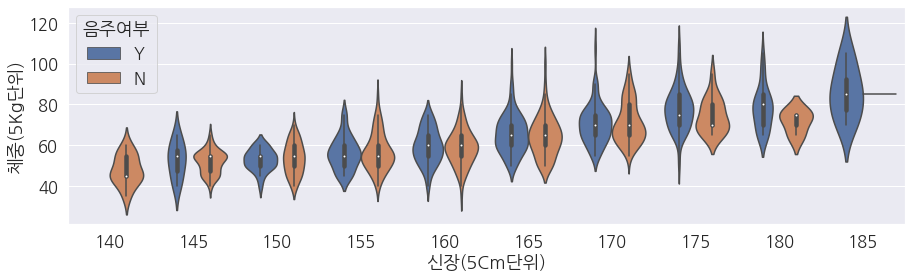

In [136]:
# violinplot 신장(5Cm단위)에 따른 체중(5Kg 단위) 을 그리며, 음주여부에 따라 다른 색상으로 표현되게 합니다.
plt.figure(figsize=(15, 4))
sns.violinplot(data=df_sample, x="신장(5Cm단위)", y="체중(5Kg단위)", hue="음주여부")

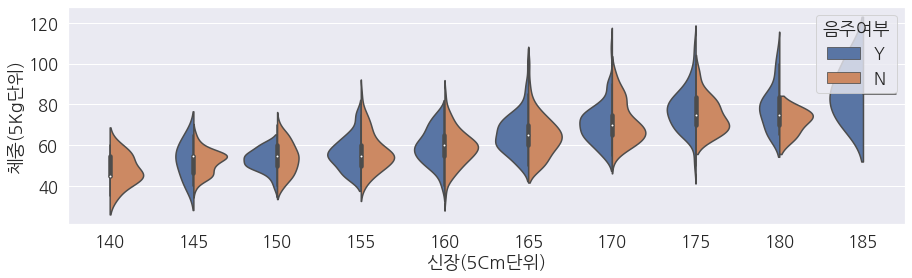

In [137]:
# violinplot의 split 기능을 사용해 봅니다. 
plt.figure(figsize=(15, 4))
sns.violinplot(data=df_sample, x="신장(5Cm단위)", y="체중(5Kg단위)", hue="음주여부", split=True)

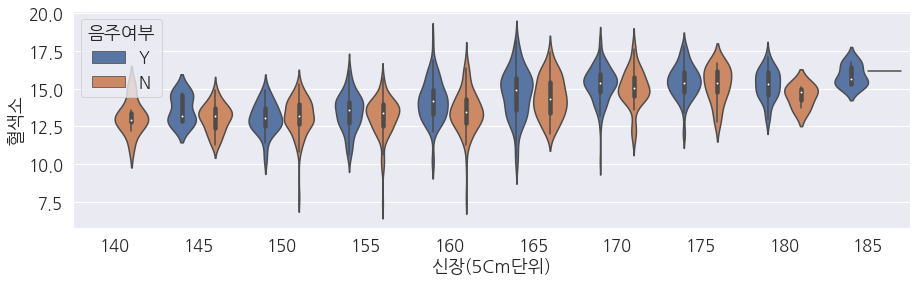

In [138]:
# violinplot 연령대코드(5세단위)에 따른 혈색소를 그리며, 음주여부에 따라 다른 색상으로 표현되게 합니다.
plt.figure(figsize=(15, 4))
sns.violinplot(data=df_sample, x="신장(5Cm단위)", y="혈색소", hue="음주여부")

### swarm plot
* 범주형 데이터를 산점도로 시각화하고자 할 때 사용합니다.

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 43.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 48.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 47.2% of the points cannot be placed; yo

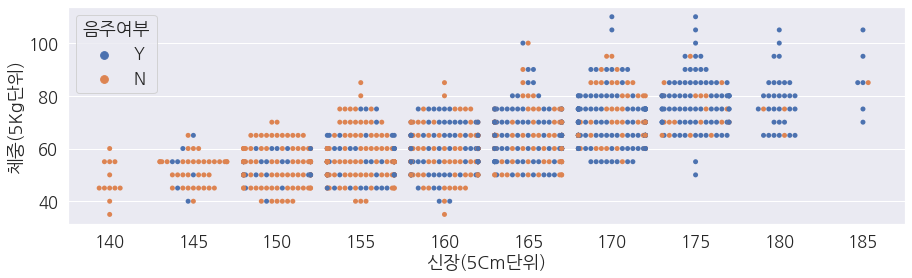

In [142]:
# swarmplot으로 신장(5Cm단위)에 따른 체중(5Kg 단위) 을 그리며, 음주여부에 따라 다른 색상으로 표현되게 합니다.
# 점을 하나씩 찍기 때문에 오래 걸리는 코드는 전체로 그려보기 전에 일부만 가져와 그려봅니다.
plt.figure(figsize=(15, 4))
sns.swarmplot(data=df_sample, x='신장(5Cm단위)',y= '체중(5Kg단위)',hue='음주여부')

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 63.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 57.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


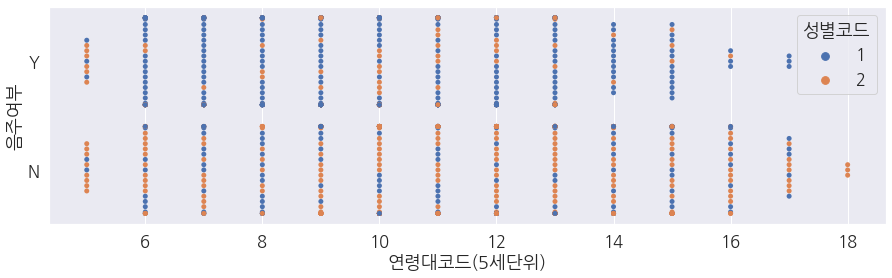

In [145]:
# swarmplot으로 연령대코드(5세단위)에 따른 음주여부 그리며, 성별코드에 따라 다른 색상으로 표현되게 합니다.
# 점을 하나씩 찍기 때문에 오래 걸리는 코드는 전체로 그려보기 전에 일부만 가져와 그려봅니다.

plt.figure(figsize=(15, 4))
sns.swarmplot(data=df_sample, x='연령대코드(5세단위)',y= '음주여부',hue='성별코드')

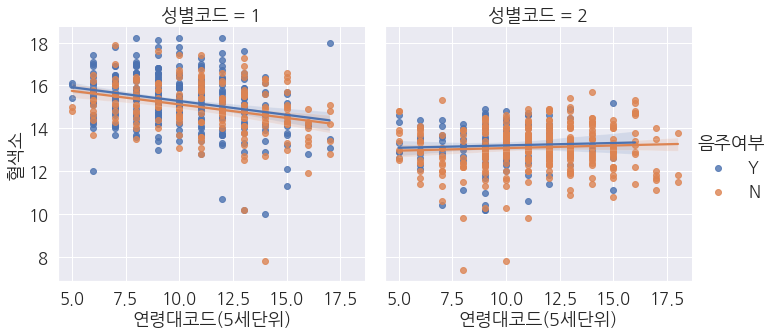

In [146]:
# lmplot 으로 그리기
sns.lmplot(data=df_sample, x="연령대코드(5세단위)", y="혈색소", hue="음주여부", col="성별코드")

## 수치형 데이터 시각화

### scatterplot - 산점도
* 수치형 vs 수치형 데이터의 상관 관계를 볼 때 주로 사용합니다.
* 점의 크기를 데이터의 수치에 따라 다르게 볼 수 있습니다.

In [59]:
# scatterplot 으로 "(혈청지오티)AST", "(혈청지오티)ALT" 을 그리고 음주여부에 따라 다른 색상으로 표현되게 합니다.


### lmplot - 상관 관계를 보기

In [60]:
# lmplot 으로 신장(5Cm단위)에 따른 체중(5Kg 단위) 을 그리며, 음주여부에 따라 다른 색상으로 표현되게 합니다.


In [61]:
# lmplot의 col기능을 통해 음주여부에 따라 서브플롯을 그려봅니다. 



In [62]:
# lmplot 으로 수축기, 이완기혈압을 그리고 음주여부에 따라 다른 색상으로 표현되게 합니다.



`AST와 ALT`
* 출처 : https://sev.iseverance.com/dept_clinic/center/liver/treatment/view.asp?con_no=87827


```
AST와 ALT는 간세포에 들어 있는 효소 입니다.

간이 손상돼 간세포가 파괴되면 그 안에 있던 AST와 ALT 가 빠져 나와 혈액 속에 섞여 돌아다니게 됩니다. 따라서 간이 손상되면 AST와 ALT 수치가 높아집니다.

정상 수치는 병원에 따라 기준치가 다소 차이가 있으나 AST가 5~35 IU/L, ALT가 5~40 IU/L 정도 입니다.

 

간혹 전날 술을 마시거나 몸이 피곤하면 일시적으로 AST와 ALT 수치가 정상치를 웃돌 수 있으므로 딱 한 번의 검사만으로 간질환 여부를 판단하는 경우는 드뭅니다. 하지만 AST 와 ALT 같은 간수치는 간의 상태를 일차적으로 파악하는데 아주 중요한 기준이 됩니다.
```

In [63]:
# lmplot으로 "(혈청지오티)AST", "(혈청지오티)ALT" 을 그리고 음주여부에 따라 다른 색상으로 표현되게 합니다.



### 이상치 다루기
* 이상치가 있으면 데이터가 자세히 보이지 않거나 이상치로 인해 회귀선이 달라지기도 합니다.
* 시각화를 통해 찾은 이상치를 제거하고 보거나 이상치만 따로 모아 보도록 합니다.

In [64]:
# "(혈청지오티)AST" 와 "(혈청지오티)ALT" 가 400 이하인 값만 데이터프레임 형태로 추출해서 
# df_ASLT 라는 변수에 담습니다.


In [65]:
# 이상치를 제거한 "(혈청지오티)AST" 와 "(혈청지오티)ALT" 를 lmplot으로 그리며 
# 음주여부에 따라 다른 색으로 표현합니다.



In [66]:
# "(혈청지오티)AST" 와 "(혈청지오티)ALT" 가 400 이상인 값만 데이터프레임 형태로 추출해서 
# df_ASLT_high 라는 변수에 담습니다.



In [67]:
# 위에서 구한 df_ASLT_high 데이터 프레임에 담겨진 혈청지오티가 높은 데이터만 따로 봅니다.



### distplot
* [히스토그램 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%ED%9E%88%EC%8A%A4%ED%86%A0%EA%B7%B8%EB%9E%A8)
* [확률 밀도 함수 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%ED%99%95%EB%A5%A0_%EB%B0%80%EB%8F%84_%ED%95%A8%EC%88%98)

In [68]:
# 수치형 데이터로 된 컬럼을 찾기 위해 컬럼명만 따로 출력합니다.



In [69]:
# "총콜레스테롤" 에 따른 distplot 을 그립니다.


In [70]:
# 음주여부가 1인 값에 대한 "총콜레스테롤" 을 distplot 으로 그립니다.



In [71]:
# 음주여부가 0인 값에 대한 "총콜레스테롤" 을 distplot 으로 그립니다.



In [72]:
# 음주여부 값에 대한 "총콜레스테롤" 을 distplot 으로 그리며, 하나의 그래프에 표시되도록 합니다.



In [73]:
# 감마지티피 값에 따라 음주여부를 시각화 합니다.



## 상관 분석
* [상관 분석 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%83%81%EA%B4%80_%EB%B6%84%EC%84%9D)

```
r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,
r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,
r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,
r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,
r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,
r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,
r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계
```

In [74]:
# 상관계수에 사용할 컬럼을 변수에 담습니다.
columns = ['연령대코드(5세단위)', '체중(5Kg 단위)', '신장(5Cm단위)', '허리둘레', 
           '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', 
           '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', 
           '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', 
           '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부']
columns

['연령대코드(5세단위)',
 '체중(5Kg 단위)',
 '신장(5Cm단위)',
 '허리둘레',
 '시력(좌)',
 '시력(우)',
 '청력(좌)',
 '청력(우)',
 '수축기혈압',
 '이완기혈압',
 '식전혈당(공복혈당)',
 '총콜레스테롤',
 '트리글리세라이드',
 'HDL콜레스테롤',
 'LDL콜레스테롤',
 '혈색소',
 '요단백',
 '혈청크레아티닌',
 '(혈청지오티)AST',
 '(혈청지오티)ALT',
 '감마지티피',
 '흡연상태',
 '음주여부']

### 상관계수 구하기

In [75]:
# 샘플컬럼만 가져와서 df_small 이라는 데이터프레임에 담은 뒤 상관계수를 구합니다.



In [76]:
# 키에 대한 상관계수가 특정 수치 이상인 데이터를 봅니다.



In [77]:
# 음주여부에 대한 상관계수가 특정 수치 이상인 데이터를 봅니다.


In [78]:
# 혈색소에 대한 상관계수가 특정 수치 이상인 데이터를 봅니다.


In [79]:
# 감마지티피에 대한 상관계수가 특정 수치 이상인 데이터를 봅니다.


### heatmap
* [Plotting a diagonal correlation matrix — seaborn 0.10.0 documentation](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

In [80]:
# 위에서 구한 상관계수를 heatmap을 통해 표현해 봅니다.
